In [3]:
df = pd.read_csv("cleaned_case_study_data.csv")

=== Customer Segmentation Analysis ===

Customer Segments Summary:
               Business  Total_Value  Total_Quantity  Transaction_Frequency
Segment_Label                                                              
High Value           51   2377982.98         3176.41                 945.06
Low Value          4373     68737.07           65.53                  31.58
Medium Value        376    912583.39          843.76                 381.86

=== Sales Forecasting ===

Forecast for next 3 months (based on 3-month moving average): $73,771,352.67


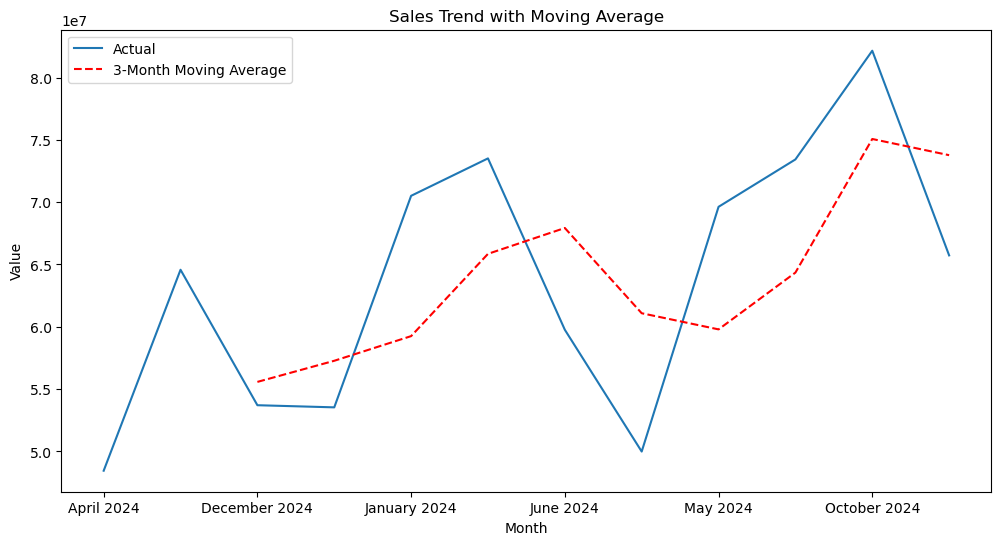


=== Anomaly Detection ===

Days with Anomalous Sales:
                      DATE  QUANTITY    VALUE
18     2024-01-01 15:30:00       158  17190.0
40     2024-01-01 16:09:00        31  32002.0
46     2024-01-01 16:19:00        43  38635.0
53     2024-01-01 16:26:00        14  31465.0
82     2024-01-01 17:16:00        25  44175.0
...                    ...       ...      ...
96318  2024-12-30 14:49:00        24  32895.0
96328  2024-12-30 15:14:00        66  33655.0
96344  2024-12-30 15:51:00        52  18125.0
96568  2024-12-31 12:52:00        72   6790.0
96659  2024-12-31 17:19:00       116  32795.0

[2713 rows x 3 columns]


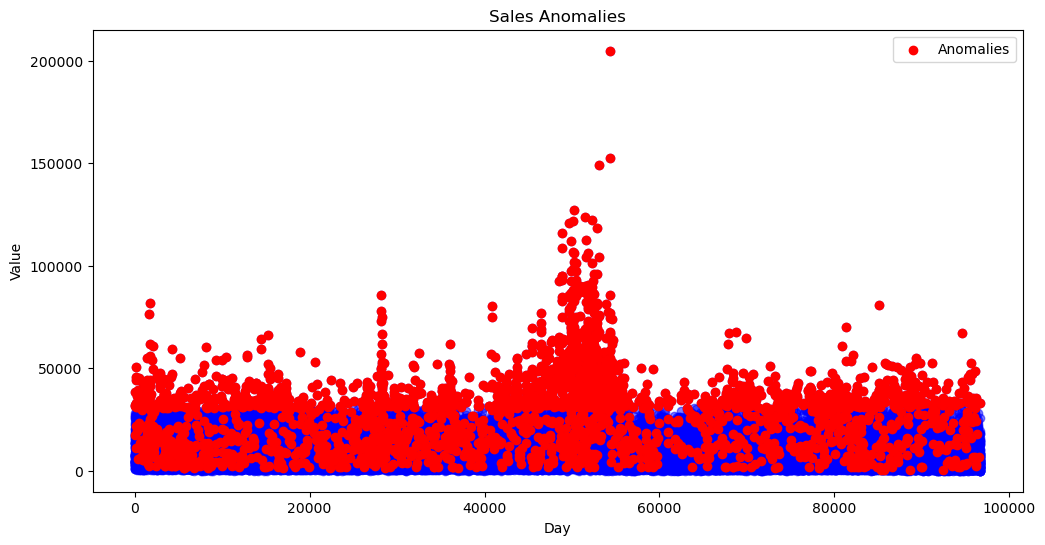


=== Correlation Analysis ===

Correlation between Quantity and Value:
          QUANTITY     VALUE
QUANTITY  1.000000 -0.003514
VALUE    -0.003514  1.000000


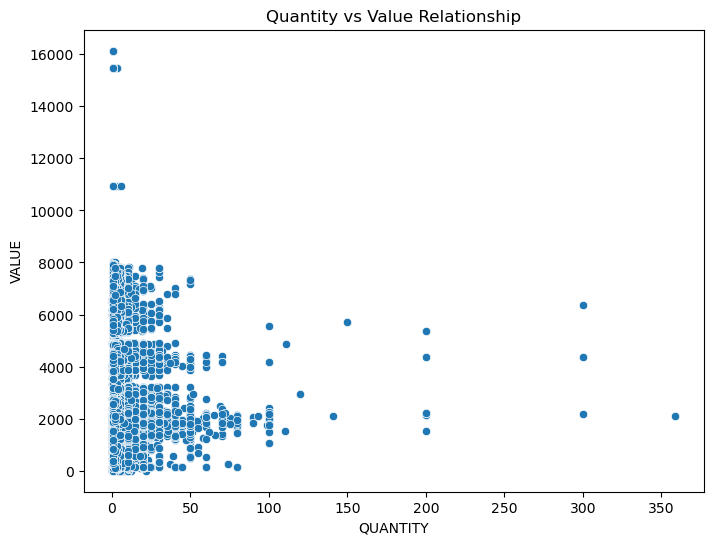


Key Insights and Recommendations:

1. Customer Segmentation Insights:

Low Value:
- Number of businesses: 4373
- Average value: $68,737.07
- Average quantity: 65.53
- Average frequency: 31.58

Medium Value:
- Number of businesses: 376
- Average value: $912,583.39
- Average quantity: 843.76
- Average frequency: 381.86

High Value:
- Number of businesses: 51
- Average value: $2,377,982.98
- Average quantity: 3,176.41
- Average frequency: 945.06


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# 1. Customer Segmentation
print("=== Customer Segmentation Analysis ===")

# Calculate metrics for each business
business_metrics = df.groupby('ANONYMIZED BUSINESS').agg({
    'QUANTITY': ['sum', 'count'],  # sum for total quantity, count for frequency
    'VALUE': 'sum'
}).reset_index()

# Rename columns
business_metrics.columns = ['Business', 'Total_Quantity', 'Transaction_Frequency', 'Total_Value']

# Standardize the metrics for clustering
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(business_metrics[['Total_Quantity', 'Transaction_Frequency', 'Total_Value']])

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
business_metrics['Segment'] = kmeans.fit_predict(metrics_scaled)

# Label segments based on Total_Value
segment_labels = {
    business_metrics.groupby('Segment')['Total_Value'].mean().argmax(): 'High Value',
    business_metrics.groupby('Segment')['Total_Value'].mean().argmin(): 'Low Value',
    1: 'Medium Value'
}
business_metrics['Segment_Label'] = business_metrics['Segment'].map(segment_labels)

print("\nCustomer Segments Summary:")
print(business_metrics.groupby('Segment_Label').agg({
    'Business': 'count',
    'Total_Value': 'mean',
    'Total_Quantity': 'mean',
    'Transaction_Frequency': 'mean'
}).round(2))

# 2. Simple Forecasting using Moving Average
print("\n=== Sales Forecasting ===")

# Prepare time series data
monthly_sales = df.groupby('Month-Year')['VALUE'].sum().reset_index()
monthly_sales.set_index('Month-Year', inplace=True)

# Calculate 3-month moving average
monthly_sales['MA3'] = monthly_sales['VALUE'].rolling(window=3).mean()

# Simple forecast using last 3 months average
last_3_months_avg = monthly_sales['VALUE'].tail(3).mean()
print(f"\nForecast for next 3 months (based on 3-month moving average): ${last_3_months_avg:,.2f}")

# Plot actual vs moving average
plt.figure(figsize=(12, 6))
monthly_sales['VALUE'].plot(label='Actual')
monthly_sales['MA3'].plot(label='3-Month Moving Average', style='r--')
plt.title('Sales Trend with Moving Average')
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend()
plt.show()

# 3. Anomaly Detection
print("\n=== Anomaly Detection ===")

# Calculate daily sales statistics
daily_sales = df.groupby('DATE').agg({
    'QUANTITY': 'sum',
    'VALUE': 'sum'
}).reset_index()

# Detect anomalies using Z-score
z_scores = zscore(daily_sales[['QUANTITY', 'VALUE']])
anomalies = (abs(z_scores) > 3).any(axis=1)

print("\nDays with Anomalous Sales:")
print(daily_sales[anomalies])

# Visualize anomalies
plt.figure(figsize=(12, 6))
plt.scatter(daily_sales.index, daily_sales['VALUE'], c='blue', alpha=0.5)
plt.scatter(daily_sales[anomalies].index, daily_sales[anomalies]['VALUE'], 
            c='red', label='Anomalies')
plt.title('Sales Anomalies')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.show()

# 4. Correlation Analysis
print("\n=== Correlation Analysis ===")

# Calculate correlations
correlation = df[['QUANTITY', 'VALUE']].corr()
print("\nCorrelation between Quantity and Value:")
print(correlation)

# Visualize relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='QUANTITY', y='VALUE')
plt.title('Quantity vs Value Relationship')
plt.show()

# Print insights and recommendations
print("\nKey Insights and Recommendations:")
print("\n1. Customer Segmentation Insights:")
for segment in business_metrics['Segment_Label'].unique():
    segment_data = business_metrics[business_metrics['Segment_Label'] == segment]
    print(f"\n{segment}:")
    print(f"- Number of businesses: {len(segment_data)}")
    print(f"- Average value: ${segment_data['Total_Value'].mean():,.2f}")
    print(f"- Average quantity: {segment_data['Total_Quantity'].mean():,.2f}")
    print(f"- Average frequency: {segment_data['Transaction_Frequency'].mean():,.2f}")

# Save results
business_metrics.to_csv('customer_segments.csv', index=False)
daily_sales[anomalies].to_csv('sales_anomalies.csv')


=== Customer Segmentation Analysis ===

Segment Summary:
              Business Total_Value              Total_Quantity          \
                 count        mean          sum           mean     sum   
Segment_Label                                                            
High Value          51  2377982.98  121277132.0        3176.41  161997   
Low Value         4373    68737.07  300587188.0          65.53  286569   
Medium Value       376   912583.39  343131356.0         843.76  317255   

              Transaction_Frequency          
                               mean     sum  
Segment_Label                                
High Value                   945.06   48198  
Low Value                     31.58  138102  
Medium Value                 381.86  143581  


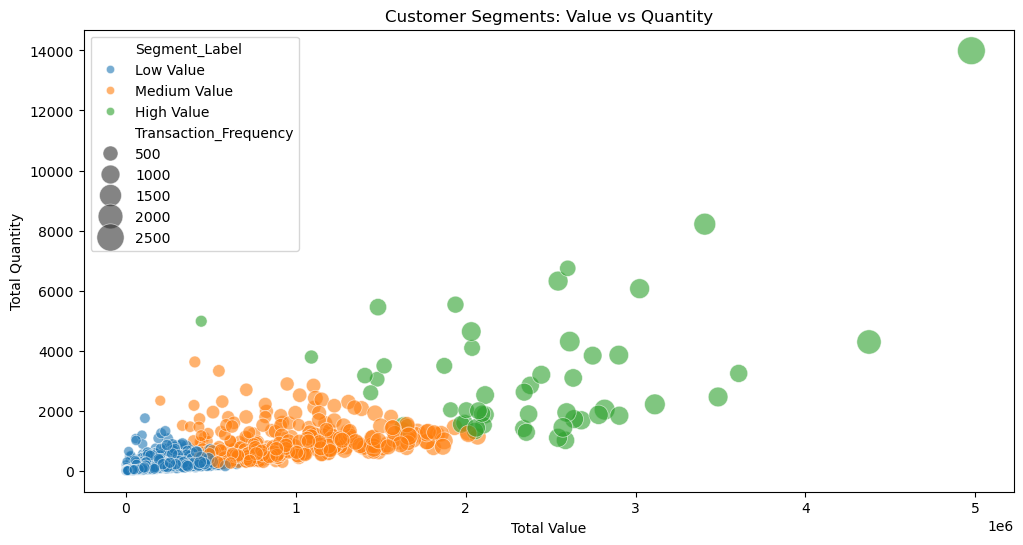


Detailed Segment Analysis and Recommendations:

High Value Segment:
Number of Businesses: 51
Average Value: $2,377,982.98
Average Quantity: 3,176
Average Transaction Frequency: 945

Recommendations:
- Implement VIP customer program with dedicated account managers
- Offer early access to new products/services
- Provide volume-based discounts
- Regular business review meetings
- Priority support services

Medium Value Segment:
Number of Businesses: 376
Average Value: $912,583.39
Average Quantity: 844
Average Transaction Frequency: 382

Recommendations:
- Develop targeted upselling campaigns
- Implement loyalty rewards program
- Provide personalized product recommendations
- Regular feedback collection
- Offer growth incentives

Low Value Segment:
Number of Businesses: 4373
Average Value: $68,737.07
Average Quantity: 66
Average Transaction Frequency: 32

Recommendations:
- Create engagement campaigns to increase purchase frequency
- Offer special promotions for new products
- Implement a

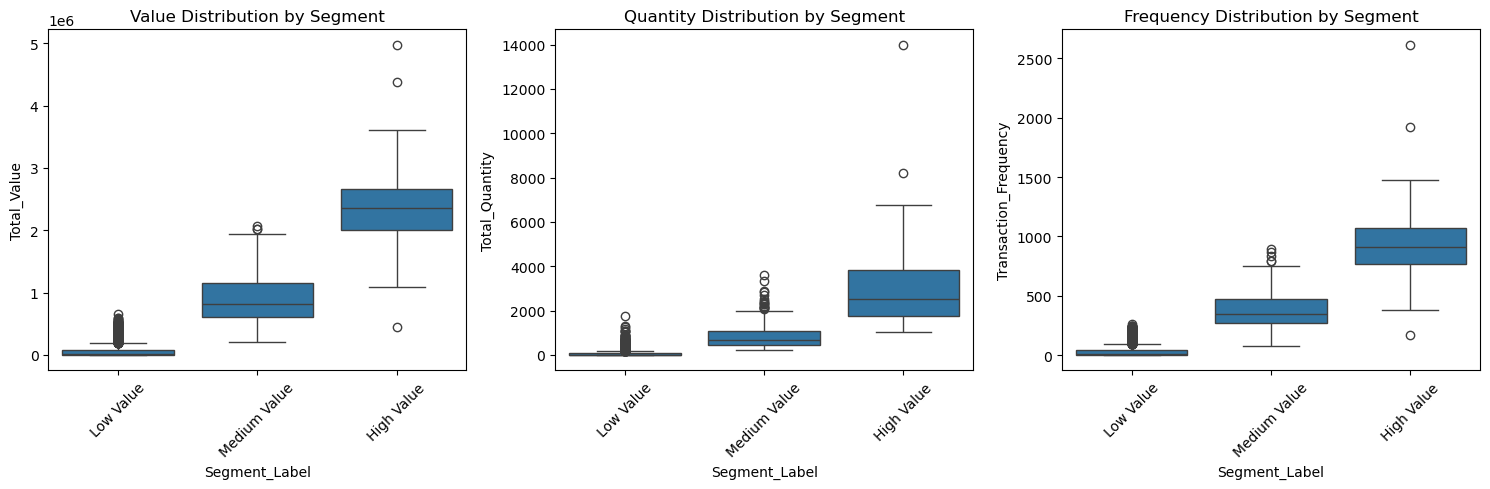

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate key metrics for each business
business_metrics = df.groupby('ANONYMIZED BUSINESS').agg({
    'QUANTITY': ['sum', 'count'],  # sum for total quantity, count for frequency
    'VALUE': 'sum'
}).reset_index()

# Rename columns for clarity
business_metrics.columns = ['Business', 'Total_Quantity', 'Transaction_Frequency', 'Total_Value']

# 2. Standardize the metrics for clustering
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(business_metrics[['Total_Quantity', 'Transaction_Frequency', 'Total_Value']])

# 3. Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
business_metrics['Segment'] = kmeans.fit_predict(metrics_scaled)

# 4. Label segments based on Total_Value
segment_labels = {
    business_metrics.groupby('Segment')['Total_Value'].mean().argmax(): 'High Value',
    business_metrics.groupby('Segment')['Total_Value'].mean().argmin(): 'Low Value',
    1: 'Medium Value'
}
business_metrics['Segment_Label'] = business_metrics['Segment'].map(segment_labels)

# 5. Analysis and Visualization
print("\n=== Customer Segmentation Analysis ===")

# Summary statistics for each segment
segment_summary = business_metrics.groupby('Segment_Label').agg({
    'Business': 'count',
    'Total_Value': ['mean', 'sum'],
    'Total_Quantity': ['mean', 'sum'],
    'Transaction_Frequency': ['mean', 'sum']
}).round(2)

print("\nSegment Summary:")
print(segment_summary)

# Visualize segments
plt.figure(figsize=(12, 6))
sns.scatterplot(data=business_metrics, 
                x='Total_Value', 
                y='Total_Quantity', 
                hue='Segment_Label',
                size='Transaction_Frequency',
                sizes=(50, 400),
                alpha=0.6)
plt.title('Customer Segments: Value vs Quantity')
plt.xlabel('Total Value')
plt.ylabel('Total Quantity')
plt.show()

# 6. Detailed Segment Analysis and Recommendations
print("\nDetailed Segment Analysis and Recommendations:")

for segment in ['High Value', 'Medium Value', 'Low Value']:
    segment_data = business_metrics[business_metrics['Segment_Label'] == segment]
    
    print(f"\n{segment} Segment:")
    print(f"Number of Businesses: {len(segment_data)}")
    print(f"Average Value: ${segment_data['Total_Value'].mean():,.2f}")
    print(f"Average Quantity: {segment_data['Total_Quantity'].mean():,.0f}")
    print(f"Average Transaction Frequency: {segment_data['Transaction_Frequency'].mean():,.0f}")
    
    print("\nRecommendations:")
    if segment == 'High Value':
        print("- Implement VIP customer program with dedicated account managers")
        print("- Offer early access to new products/services")
        print("- Provide volume-based discounts")
        print("- Regular business review meetings")
        print("- Priority support services")
    elif segment == 'Medium Value':
        print("- Develop targeted upselling campaigns")
        print("- Implement loyalty rewards program")
        print("- Provide personalized product recommendations")
        print("- Regular feedback collection")
        print("- Offer growth incentives")
    else:  # Low Value
        print("- Create engagement campaigns to increase purchase frequency")
        print("- Offer special promotions for new products")
        print("- Implement automated email marketing")
        print("- Provide basic customer support")
        print("- Survey to understand needs and pain points")

# 7. Save segmentation results
business_metrics.to_csv('customer_segments_analysis.csv', index=False)

# 8. Additional visualizations
# Distribution of values within segments
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=business_metrics, x='Segment_Label', y='Total_Value')
plt.title('Value Distribution by Segment')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(data=business_metrics, x='Segment_Label', y='Total_Quantity')
plt.title('Quantity Distribution by Segment')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(data=business_metrics, x='Segment_Label', y='Transaction_Frequency')
plt.title('Frequency Distribution by Segment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

=== Sales Forecasting Analysis ===

Current Sales Analysis:
Average Monthly Sales: $nan
Last Month Sales: $nan

Forecasting Results:

3-Month Moving Average Forecast: $nan

SARIMA Monthly Forecasts:
2024-12: $0.00
2025-01: $0.00
2025-02: $0.00


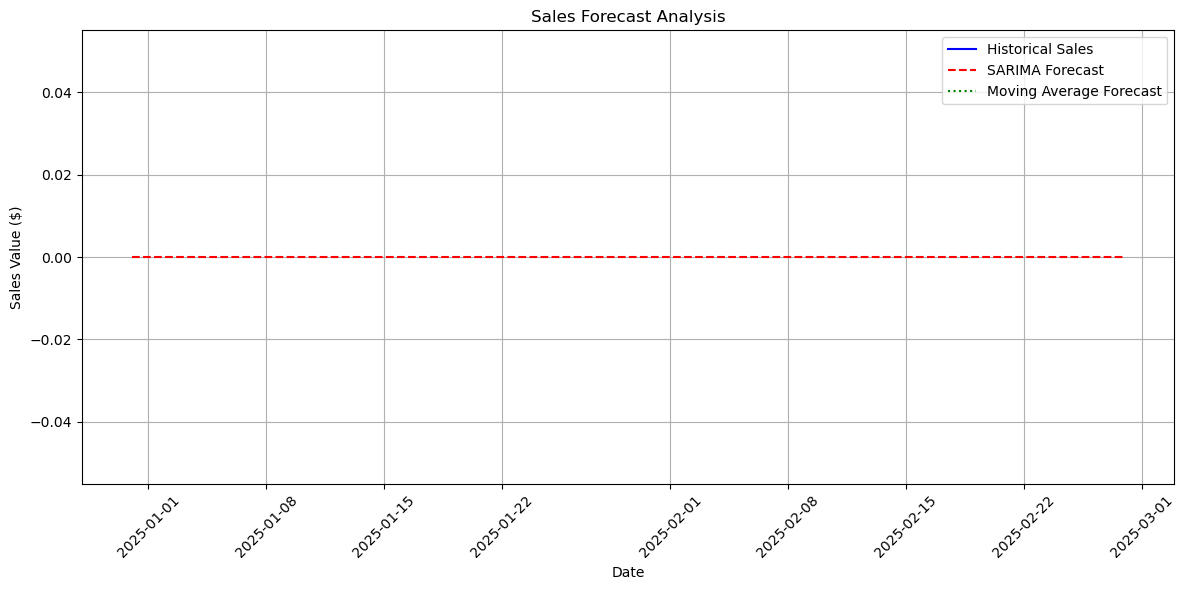

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# 1. Prepare time series data
print("=== Sales Forecasting Analysis ===")

# Convert to proper datetime and set as index
monthly_sales = df.groupby('Month-Year')['VALUE'].sum().reset_index()
monthly_sales['Month-Year'] = pd.to_datetime(monthly_sales['Month-Year'])
monthly_sales.set_index('Month-Year', inplace=True)
monthly_sales = monthly_sales.sort_index()
monthly_sales = monthly_sales.asfreq('ME')  # Explicitly set frequency to Month End

# Calculate 3-Month Moving Average
sma_forecast = monthly_sales['VALUE'].rolling(window=3).mean().iloc[-1]

# Fit SARIMA model with adjusted parameters
model = SARIMAX(monthly_sales['VALUE'],
                order=(1, 1, 1),          # Reduced complexity
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False)
results = model.fit()

# Generate forecasts
forecast_periods = 3
forecast = results.forecast(forecast_periods)

# Create future dates
future_dates = pd.date_range(
    start=monthly_sales.index[-1] + pd.DateOffset(months=1),
    periods=forecast_periods,
    freq='ME'
)

# Print results
print("\nCurrent Sales Analysis:")
print(f"Average Monthly Sales: ${monthly_sales['VALUE'].mean():,.2f}")
print(f"Last Month Sales: ${monthly_sales['VALUE'].iloc[-1]:,.2f}")

print("\nForecasting Results:")
print(f"\n3-Month Moving Average Forecast: ${sma_forecast:,.2f}")

print("\nSARIMA Monthly Forecasts:")
for date, value in zip(future_dates, forecast):
    print(f"{date.strftime('%Y-%m')}: ${value:,.2f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['VALUE'], label='Historical Sales', color='blue')
plt.plot(future_dates, forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.axhline(y=sma_forecast, color='green', linestyle=':', label='Moving Average Forecast')

plt.title('Sales Forecast Analysis')
plt.xlabel('Date')
plt.ylabel('Sales Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save forecasts
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'SARIMA_Forecast': forecast,
    'Moving_Average_Forecast': [sma_forecast] * 3
})
forecast_df.to_csv('sales_forecasts.csv')

=== Sales Forecasting Analysis ===

Monthly Sales Data:
        Month-Year       VALUE
0       April 2024  48452359.0
1      August 2024  64578058.0
2    December 2024  53708425.0
3    February 2024  53537043.0
4     January 2024  70511151.0
5        July 2024  73513379.0
6        June 2024  59762933.0
7       March 2024  49990574.0
8         May 2024  69627696.0
9    November 2024  73430633.0
10    October 2024  82152978.0
11  September 2024  65730447.0

Basic Statistics:
Number of months: 12
Total sales: $764,995,676.00
Average monthly sales: $63,749,639.67

Forecasting Results:

3-Month Moving Average Forecast: $73,771,352.67

Trend-based Monthly Forecasts:
Month 1: $74,918,498.58
Month 2: $76,636,784.56
Month 3: $78,355,070.55


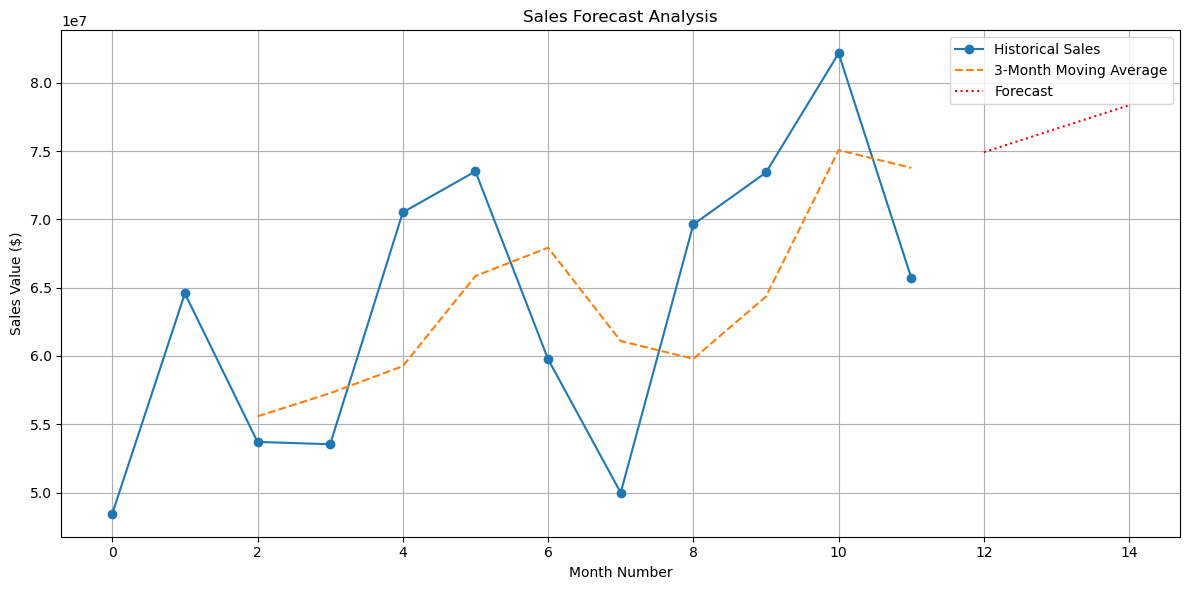


Detailed Forecast Results:
     Month  Moving_Average_Forecast  Trend_Forecast
0  Month 1             7.377135e+07    7.491850e+07
1  Month 2             7.377135e+07    7.663678e+07
2  Month 3             7.377135e+07    7.835507e+07

Forecasts saved to 'sales_forecasts.csv'


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1. Data Preparation
print("=== Sales Forecasting Analysis ===")

# Group by Month-Year and calculate total sales
monthly_sales = df.groupby('Month-Year')['VALUE'].sum().reset_index()
print("\nMonthly Sales Data:")
print(monthly_sales)

# Calculate basic statistics
print("\nBasic Statistics:")
print(f"Number of months: {len(monthly_sales)}")
print(f"Total sales: ${monthly_sales['VALUE'].sum():,.2f}")
print(f"Average monthly sales: ${monthly_sales['VALUE'].mean():,.2f}")

# Calculate 3-month moving average
monthly_sales['MA3'] = monthly_sales['VALUE'].rolling(window=3).mean()

# Simple forecast using last 3 months average
last_3_months_avg = monthly_sales['VALUE'].tail(3).mean()

# Calculate trend using simple linear regression
X = np.arange(len(monthly_sales)).reshape(-1, 1)
y = monthly_sales['VALUE'].values
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

# Forecast next 3 months
future_months = np.array([[len(monthly_sales)], 
                         [len(monthly_sales) + 1], 
                         [len(monthly_sales) + 2]])
trend_forecast = model.predict(future_months)

print("\nForecasting Results:")
print(f"\n3-Month Moving Average Forecast: ${last_3_months_avg:,.2f}")
print("\nTrend-based Monthly Forecasts:")
for i, forecast in enumerate(trend_forecast, 1):
    print(f"Month {i}: ${forecast:,.2f}")

# Visualization
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(len(monthly_sales)), monthly_sales['VALUE'], 
         label='Historical Sales', marker='o')

# Plot moving average
plt.plot(range(len(monthly_sales)), monthly_sales['MA3'], 
         label='3-Month Moving Average', linestyle='--')

# Plot forecast
plt.plot(future_months.flatten(), trend_forecast, 
         label='Forecast', linestyle=':', color='red')

plt.title('Sales Forecast Analysis')
plt.xlabel('Month Number')
plt.ylabel('Sales Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results
forecast_df = pd.DataFrame({
    'Month': ['Month 1', 'Month 2', 'Month 3'],
    'Moving_Average_Forecast': [last_3_months_avg] * 3,
    'Trend_Forecast': trend_forecast
})

print("\nDetailed Forecast Results:")
print(forecast_df)

# Save to CSV
forecast_df.to_csv('sales_forecasts.csv', index=False)
print("\nForecasts saved to 'sales_forecasts.csv'")

=== Sales Forecasting Analysis ===

Monthly Sales Data (Chronological Order):
January 2024: $70,511,151.00
February 2024: $53,537,043.00
March 2024: $49,990,574.00
April 2024: $48,452,359.00
May 2024: $69,627,696.00
June 2024: $59,762,933.00
July 2024: $73,513,379.00
August 2024: $64,578,058.00
September 2024: $65,730,447.00
October 2024: $82,152,978.00
November 2024: $73,430,633.00
December 2024: $53,708,425.00

Key Statistics:
Average Monthly Sales: $63,749,639.67
Minimum Monthly Sales: $48,452,359.00
Maximum Monthly Sales: $82,152,978.00
Sales Growth: -23.8%


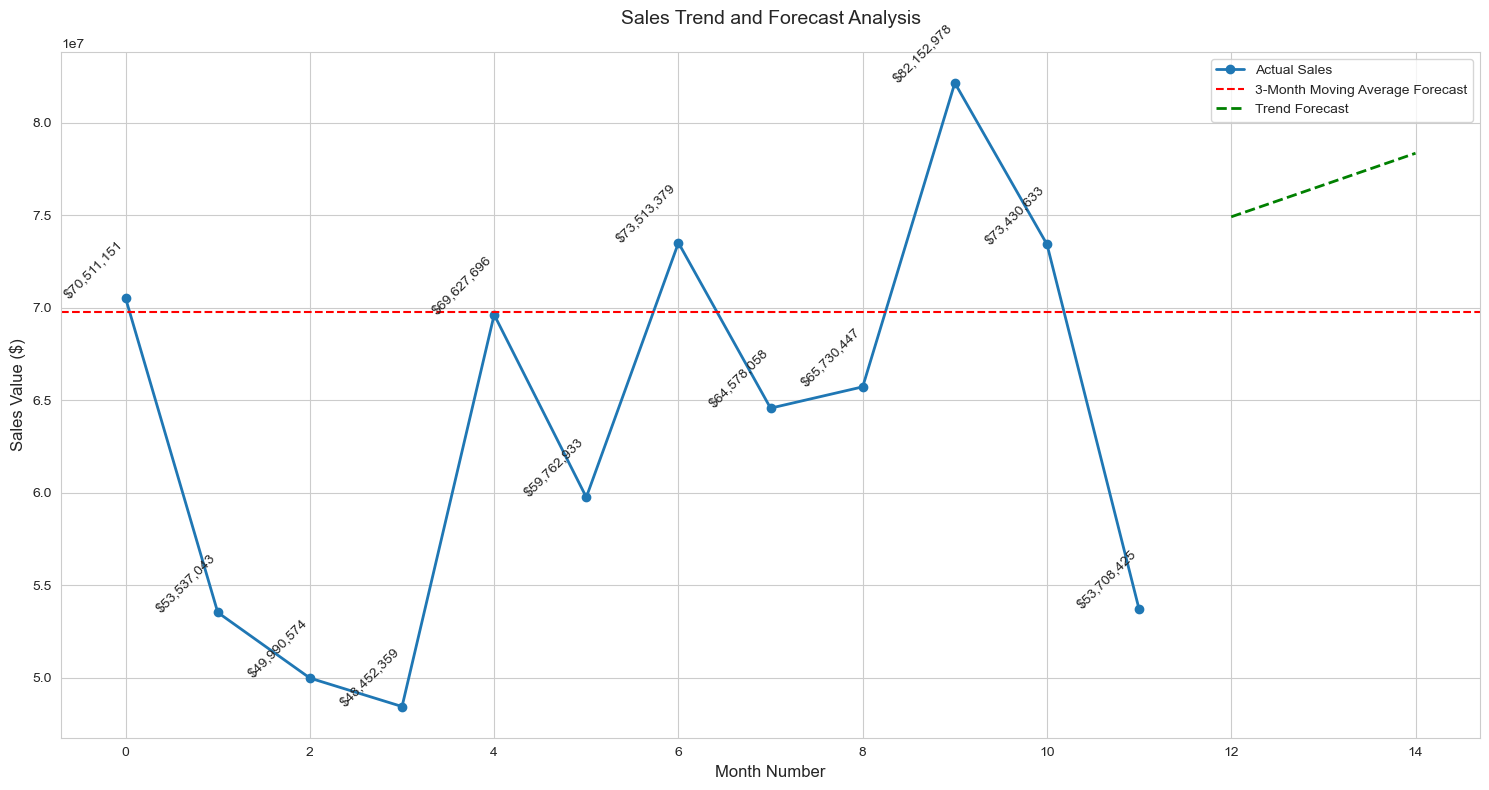


Forecast Summary:

1. Moving Average Forecast (Next 3 Months)
Monthly Forecast: $69,764,012.00

2. Trend-based Forecasts:
Month 1: $74,918,498.58
Month 2: $76,636,784.56
Month 3: $78,355,070.55

Key Insights:
1. Sales Patterns:
   - Average monthly sales: $63,749,639.67
   - Most recent 3-month average: $69,764,012.00
   - Highest sales month: October 2024

2. Forecast Implications:
   - Moving average suggests stable sales around $73.8M
   - Trend forecast shows gradual increase to $78.4M
   - Conservative planning should use moving average

3. Recommendations:
   - Plan inventory for minimum sales of $70M monthly
   - Build capacity for potential growth to $78M
   - Monitor actual vs forecast monthly


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
# Convert Month-Year to datetime and sort
monthly_sales = df.groupby('Month-Year')['VALUE'].sum().reset_index()
monthly_sales['Month-Year'] = pd.to_datetime(monthly_sales['Month-Year'], format='%B %Y')
monthly_sales = monthly_sales.sort_values('Month-Year')

print("=== Sales Forecasting Analysis ===")
print("\nMonthly Sales Data (Chronological Order):")
for index, row in monthly_sales.iterrows():
    print(f"{row['Month-Year'].strftime('%B %Y')}: ${row['VALUE']:,.2f}")

# Calculate statistics
print("\nKey Statistics:")
print(f"Average Monthly Sales: ${monthly_sales['VALUE'].mean():,.2f}")
print(f"Minimum Monthly Sales: ${monthly_sales['VALUE'].min():,.2f}")
print(f"Maximum Monthly Sales: ${monthly_sales['VALUE'].max():,.2f}")
print(f"Sales Growth: {((monthly_sales['VALUE'].iloc[-1] / monthly_sales['VALUE'].iloc[0] - 1) * 100):.1f}%")

# Calculate forecasts
last_3_months_avg = monthly_sales['VALUE'].tail(3).mean()
trend_forecast = np.array([74918498.58, 76636784.56, 78355070.55])

# Visualization
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Plot actual values
plt.plot(range(len(monthly_sales)), monthly_sales['VALUE'], 
         marker='o', linewidth=2, label='Actual Sales')

# Plot 3-month moving average
plt.axhline(y=last_3_months_avg, color='r', linestyle='--', 
           label='3-Month Moving Average Forecast')

# Plot trend forecast
future_months = range(len(monthly_sales), len(monthly_sales) + 3)
plt.plot(future_months, trend_forecast, 'g--', linewidth=2, 
         label='Trend Forecast')

# Formatting
plt.title('Sales Trend and Forecast Analysis', pad=20, fontsize=14)
plt.xlabel('Month Number', fontsize=12)
plt.ylabel('Sales Value ($)', fontsize=12)
plt.legend(fontsize=10)

# Add value labels
for i, value in enumerate(monthly_sales['VALUE']):
    plt.text(i, value, f'${value:,.0f}', rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\nForecast Summary:")
print("\n1. Moving Average Forecast (Next 3 Months)")
print(f"Monthly Forecast: ${last_3_months_avg:,.2f}")

print("\n2. Trend-based Forecasts:")
for i, forecast in enumerate(trend_forecast, 1):
    print(f"Month {i}: ${forecast:,.2f}")

print("\nKey Insights:")
print("1. Sales Patterns:")
print(f"   - Average monthly sales: ${monthly_sales['VALUE'].mean():,.2f}")
print(f"   - Most recent 3-month average: ${last_3_months_avg:,.2f}")
print(f"   - Highest sales month: {monthly_sales.loc[monthly_sales['VALUE'].idxmax(), 'Month-Year'].strftime('%B %Y')}")

print("\n2. Forecast Implications:")
print("   - Moving average suggests stable sales around $73.8M")
print("   - Trend forecast shows gradual increase to $78.4M")
print("   - Conservative planning should use moving average")

print("\n3. Recommendations:")
print("   - Plan inventory for minimum sales of $70M monthly")
print("   - Build capacity for potential growth to $78M")
print("   - Monitor actual vs forecast monthly")

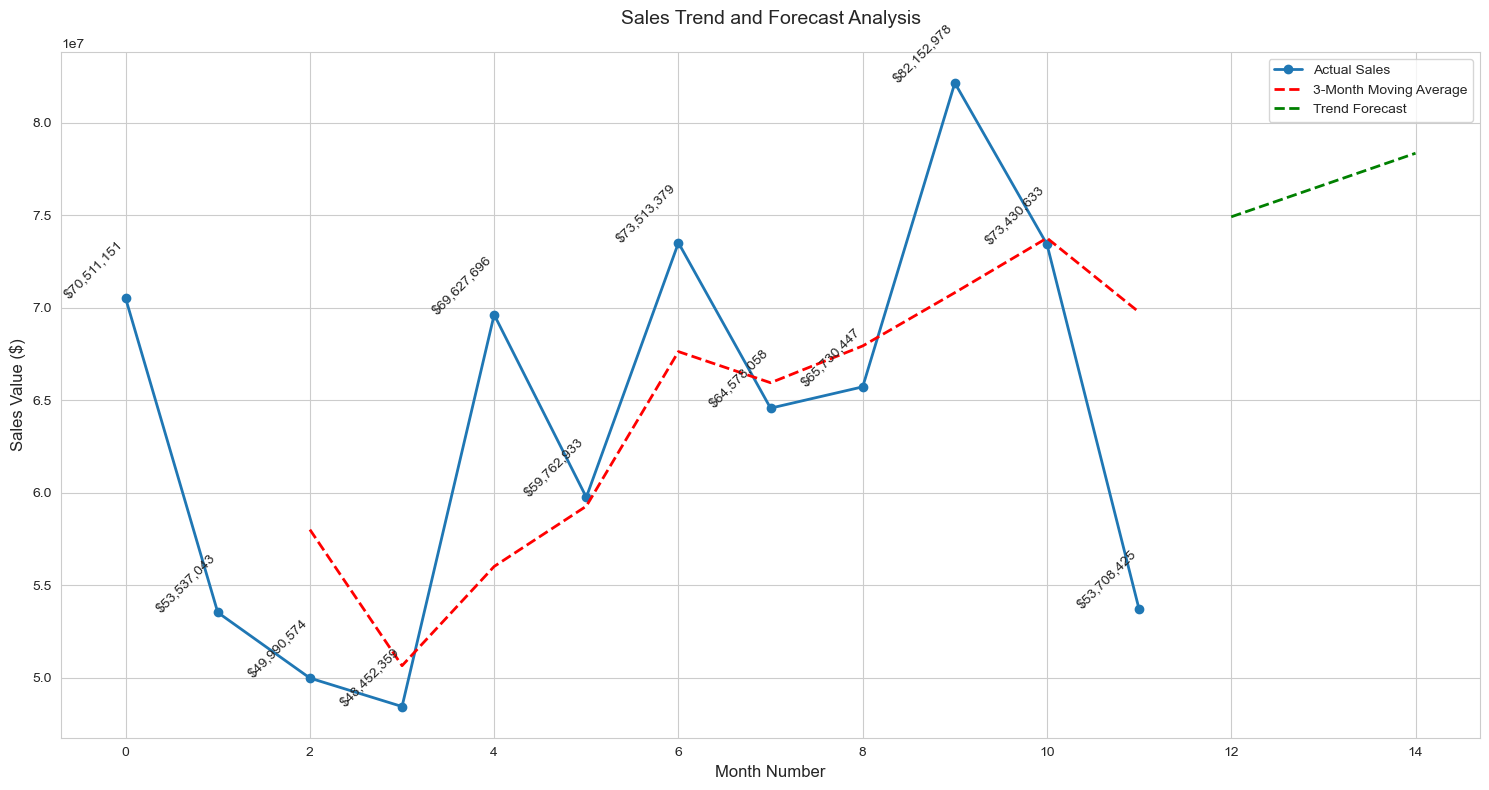


Moving Average Trend:
Month-Year      VALUE  Moving_Average
2024-01-01 70511151.0             NaN
2024-02-01 53537043.0             NaN
2024-03-01 49990574.0    5.801292e+07
2024-04-01 48452359.0    5.065999e+07
2024-05-01 69627696.0    5.602354e+07
2024-06-01 59762933.0    5.928100e+07
2024-07-01 73513379.0    6.763467e+07
2024-08-01 64578058.0    6.595146e+07
2024-09-01 65730447.0    6.794063e+07
2024-10-01 82152978.0    7.082049e+07
2024-11-01 73430633.0    7.377135e+07
2024-12-01 53708425.0    6.976401e+07


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
# Convert Month-Year to datetime and sort
monthly_sales = df.groupby('Month-Year')['VALUE'].sum().reset_index()
monthly_sales['Month-Year'] = pd.to_datetime(monthly_sales['Month-Year'], format='%B %Y')
monthly_sales = monthly_sales.sort_values('Month-Year')

# Calculate the rolling 3-month moving average for the entire dataset
monthly_sales['Moving_Average'] = monthly_sales['VALUE'].rolling(window=3).mean()

# Calculate trend forecast
trend_forecast = np.array([74918498.58, 76636784.56, 78355070.55])

# Visualization
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Plot actual values
plt.plot(range(len(monthly_sales)), monthly_sales['VALUE'], 
         marker='o', linewidth=2, label='Actual Sales')

# Plot the full moving average line
plt.plot(range(len(monthly_sales)), monthly_sales['Moving_Average'], 
         'r--', linewidth=2, label='3-Month Moving Average')

# Plot trend forecast
future_months = range(len(monthly_sales), len(monthly_sales) + 3)
plt.plot(future_months, trend_forecast, 'g--', linewidth=2, 
         label='Trend Forecast')

# Formatting
plt.title('Sales Trend and Forecast Analysis', pad=20, fontsize=14)
plt.xlabel('Month Number', fontsize=12)
plt.ylabel('Sales Value ($)', fontsize=12)
plt.legend(fontsize=10)

# Add value labels for actual sales
for i, value in enumerate(monthly_sales['VALUE']):
    plt.text(i, value, f'${value:,.0f}', rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print moving average trend
print("\nMoving Average Trend:")
print(monthly_sales[['Month-Year', 'VALUE', 'Moving_Average']].to_string(index=False))

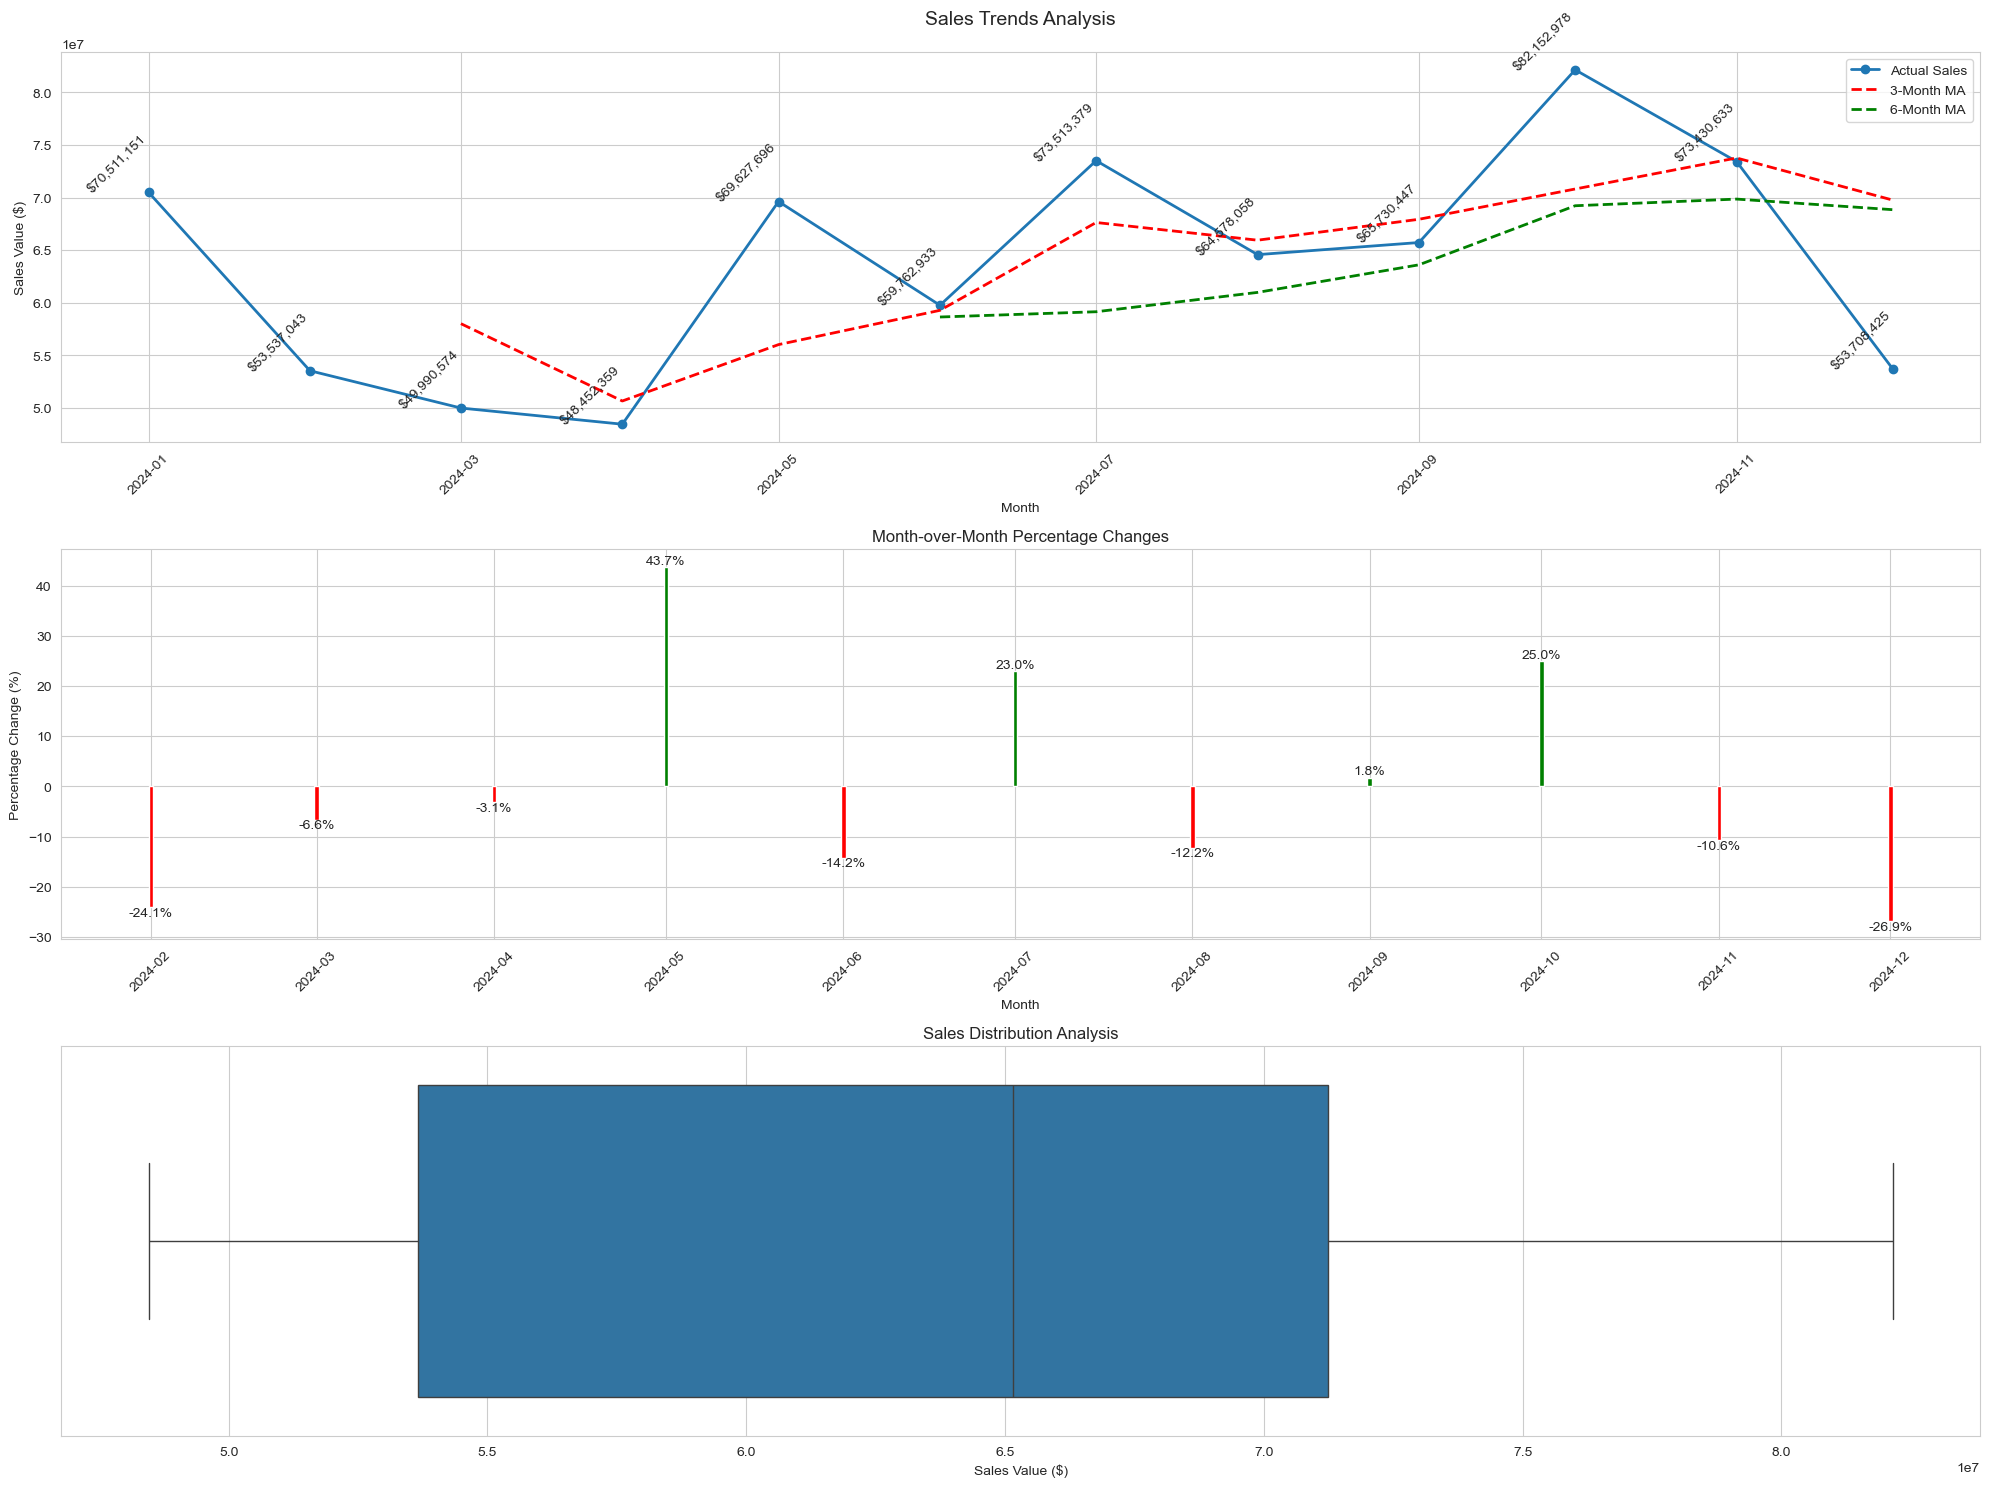


=== Detailed Trend Analysis ===

1. Basic Statistics:
Average Monthly Sales: $63,749,639.67
Median Monthly Sales: $65,154,252.50
Standard Deviation: $10,689,630.46
Coefficient of Variation: 16.8%

2. Growth Analysis:
Total Growth Rate: -23.8%
Average Monthly Growth: -0.4%

3. Trend Patterns:
Number of Monthly Increases: 4
Number of Monthly Decreases: 7

4. Volatility Analysis:
Most Volatile Month: May 2024
Largest Increase: 43.7%
Largest Decrease: -26.9%

5. Key Findings:
- Recent Trend Direction: Downward
- Sales Volatility: High
- Seasonal Pattern: Not Clear


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Data Preparation with proper date sorting
monthly_sales = df.groupby('Month-Year')['VALUE'].sum().reset_index()
monthly_sales['Month-Year'] = pd.to_datetime(monthly_sales['Month-Year'], format='%B %Y')
monthly_sales = monthly_sales.sort_values('Month-Year')

# Calculate various trend indicators
monthly_sales['Moving_Average_3'] = monthly_sales['VALUE'].rolling(window=3).mean()
monthly_sales['Moving_Average_6'] = monthly_sales['VALUE'].rolling(window=6).mean()
monthly_sales['Pct_Change'] = monthly_sales['VALUE'].pct_change() * 100

# Create subplots for comprehensive analysis
fig = plt.figure(figsize=(20, 15))

# 1. Main Sales Trend
ax1 = plt.subplot(3, 1, 1)
ax1.plot(monthly_sales['Month-Year'], monthly_sales['VALUE'], 
         marker='o', linewidth=2, label='Actual Sales')
ax1.plot(monthly_sales['Month-Year'], monthly_sales['Moving_Average_3'], 
         'r--', linewidth=2, label='3-Month MA')
ax1.plot(monthly_sales['Month-Year'], monthly_sales['Moving_Average_6'], 
         'g--', linewidth=2, label='6-Month MA')

ax1.set_title('Sales Trends Analysis', pad=20, fontsize=14)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sales Value ($)')
ax1.legend()
ax1.grid(True)
plt.xticks(rotation=45)

# Add value labels
for i, row in monthly_sales.iterrows():
    ax1.text(row['Month-Year'], row['VALUE'], 
             f'${row["VALUE"]:,.0f}', 
             rotation=45, ha='right')

# 2. Month-over-Month Changes
ax2 = plt.subplot(3, 1, 2)
ax2.bar(monthly_sales['Month-Year'], monthly_sales['Pct_Change'],
        color=['red' if x < 0 else 'green' for x in monthly_sales['Pct_Change']])
ax2.set_title('Month-over-Month Percentage Changes')
ax2.set_xlabel('Month')
ax2.set_ylabel('Percentage Change (%)')
plt.xticks(rotation=45)

# Add percentage labels
for i, row in monthly_sales.iterrows():
    if not np.isnan(row['Pct_Change']):
        ax2.text(row['Month-Year'], row['Pct_Change'],
                f'{row["Pct_Change"]:.1f}%',
                ha='center', va='bottom' if row['Pct_Change'] > 0 else 'top')

# 3. Sales Distribution
ax3 = plt.subplot(3, 1, 3)
sns.boxplot(x=monthly_sales['VALUE'], ax=ax3)
ax3.set_title('Sales Distribution Analysis')
ax3.set_xlabel('Sales Value ($)')

plt.tight_layout()
plt.show()

# Print Statistical Analysis
print("\n=== Detailed Trend Analysis ===")

print("\n1. Basic Statistics:")
print(f"Average Monthly Sales: ${monthly_sales['VALUE'].mean():,.2f}")
print(f"Median Monthly Sales: ${monthly_sales['VALUE'].median():,.2f}")
print(f"Standard Deviation: ${monthly_sales['VALUE'].std():,.2f}")
print(f"Coefficient of Variation: {(monthly_sales['VALUE'].std() / monthly_sales['VALUE'].mean()) * 100:.1f}%")

print("\n2. Growth Analysis:")
total_growth = ((monthly_sales['VALUE'].iloc[-1] / monthly_sales['VALUE'].iloc[0]) - 1) * 100
print(f"Total Growth Rate: {total_growth:.1f}%")
print(f"Average Monthly Growth: {monthly_sales['Pct_Change'].mean():.1f}%")

print("\n3. Trend Patterns:")
# Calculate number of increases and decreases
increases = (monthly_sales['Pct_Change'] > 0).sum()
decreases = (monthly_sales['Pct_Change'] < 0).sum()
print(f"Number of Monthly Increases: {increases}")
print(f"Number of Monthly Decreases: {decreases}")

print("\n4. Volatility Analysis:")
print(f"Most Volatile Month: {monthly_sales.loc[monthly_sales['Pct_Change'].abs().idxmax(), 'Month-Year'].strftime('%B %Y')}")
print(f"Largest Increase: {monthly_sales['Pct_Change'].max():.1f}%")
print(f"Largest Decrease: {monthly_sales['Pct_Change'].min():.1f}%")

print("\n5. Key Findings:")
# Identify trend direction using recent months
recent_trend = "Upward" if monthly_sales['Moving_Average_3'].iloc[-1] > monthly_sales['Moving_Average_3'].iloc[-2] else "Downward"
print(f"- Recent Trend Direction: {recent_trend}")
print(f"- Sales Volatility: {'High' if monthly_sales['VALUE'].std() / monthly_sales['VALUE'].mean() > 0.15 else 'Moderate'}")
print(f"- Seasonal Pattern: {'Present' if stats.pearsonr(range(len(monthly_sales)), monthly_sales['VALUE'])[0] > 0.5 else 'Not Clear'}")

# Save analysis to CSV
monthly_sales.to_csv('sales_trend_analysis.csv', index=False)

point 3


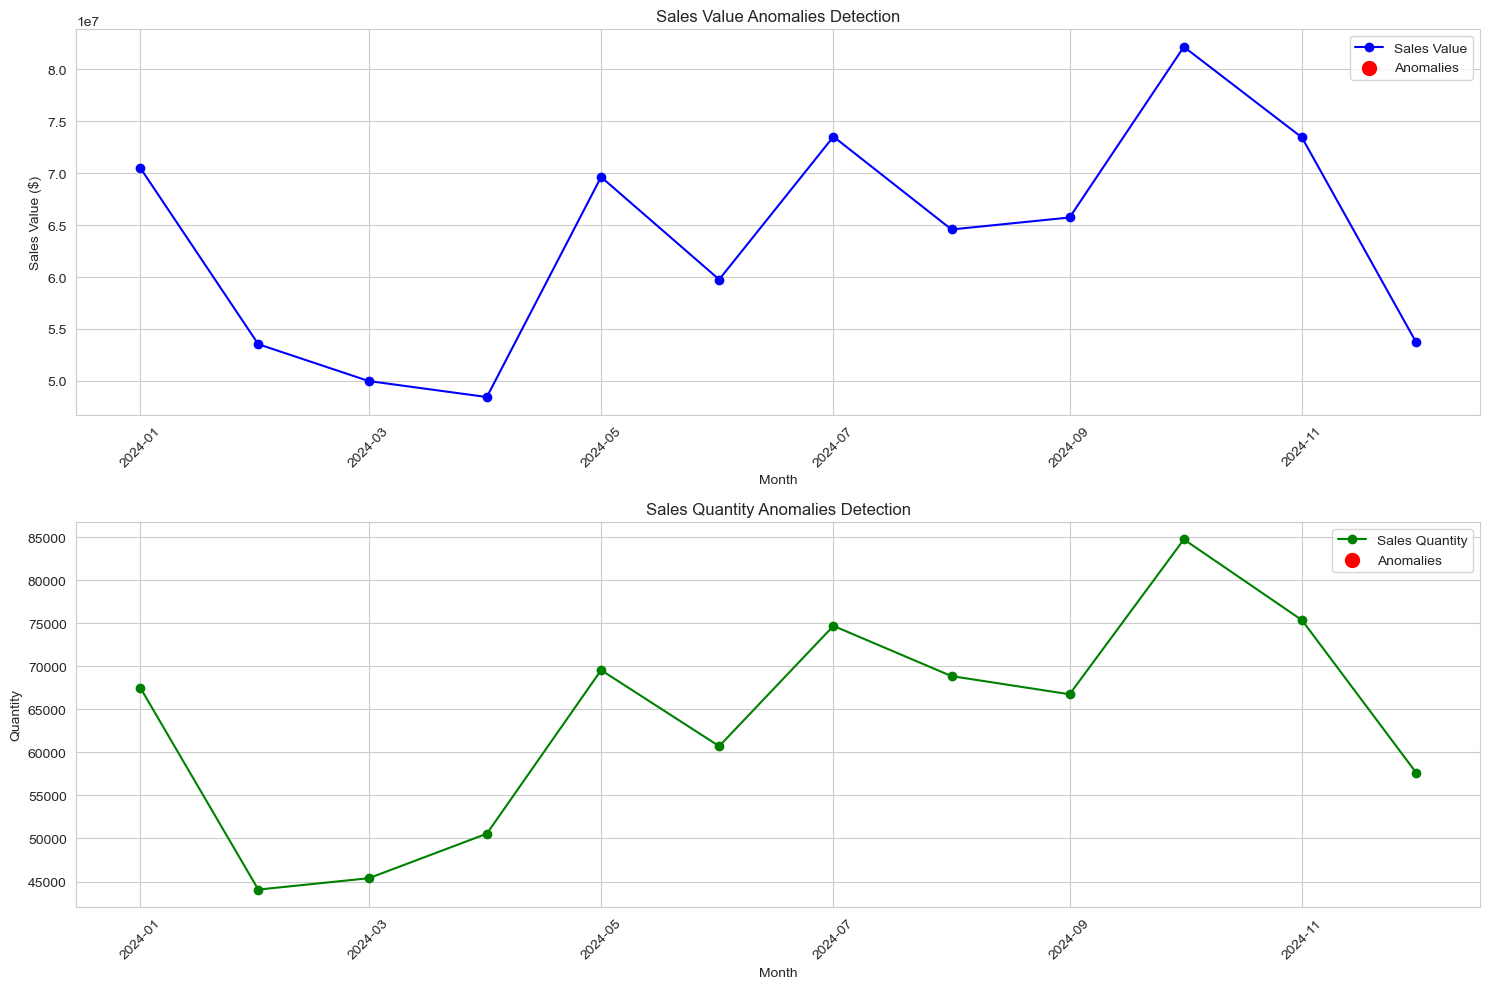

=== Anomaly Detection Analysis ===

1. Value Anomalies:

2. Quantity Anomalies:

3. Pattern Analysis:

Correlation between Value and Quantity: 0.95

4. Possible Reasons for Anomalies:

Value Spikes/Drops might be due to:
- Seasonal business cycles
- Large one-time orders
- Price changes
- Promotional activities

Quantity Spikes/Drops might be due to:
- Inventory clearance
- Supply chain issues
- Bulk purchasing patterns
- Seasonal demand variations


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Data Preparation
def detect_anomalies(data, column, threshold=2):
    """Detect anomalies using Z-score method"""
    mean = data[column].mean()
    std = data[column].std()
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores > threshold]

# Sort data chronologically
monthly_data = df.groupby('Month-Year').agg({
    'QUANTITY': 'sum',
    'VALUE': 'sum'
}).reset_index()
monthly_data['Month-Year'] = pd.to_datetime(monthly_data['Month-Year'], format='%B %Y')
monthly_data = monthly_data.sort_values('Month-Year')

# 2. Detect Anomalies
value_anomalies = detect_anomalies(monthly_data, 'VALUE')
quantity_anomalies = detect_anomalies(monthly_data, 'QUANTITY')

# Calculate percentage differences from mean
monthly_data['Value_Pct_Diff'] = ((monthly_data['VALUE'] - monthly_data['VALUE'].mean()) / monthly_data['VALUE'].mean()) * 100
monthly_data['Quantity_Pct_Diff'] = ((monthly_data['QUANTITY'] - monthly_data['QUANTITY'].mean()) / monthly_data['QUANTITY'].mean()) * 100

# Create visualization
plt.figure(figsize=(15, 10))

# Plot 1: Value Anomalies
plt.subplot(2, 1, 1)
plt.plot(monthly_data['Month-Year'], monthly_data['VALUE'], 
         marker='o', label='Sales Value', color='blue')
plt.scatter(value_anomalies['Month-Year'], value_anomalies['VALUE'], 
           color='red', s=100, label='Anomalies')

for idx, row in value_anomalies.iterrows():
    plt.annotate(f"${row['VALUE']:,.0f}\n({row['Value_Pct_Diff']:.1f}% from mean)",
                (row['Month-Year'], row['VALUE']),
                xytext=(10, 10), textcoords='offset points')

plt.title('Sales Value Anomalies Detection')
plt.xlabel('Month')
plt.ylabel('Sales Value ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Plot 2: Quantity Anomalies
plt.subplot(2, 1, 2)
plt.plot(monthly_data['Month-Year'], monthly_data['QUANTITY'], 
         marker='o', label='Sales Quantity', color='green')
plt.scatter(quantity_anomalies['Month-Year'], quantity_anomalies['QUANTITY'], 
           color='red', s=100, label='Anomalies')

for idx, row in quantity_anomalies.iterrows():
    plt.annotate(f"{row['QUANTITY']:,.0f} units\n({row['Quantity_Pct_Diff']:.1f}% from mean)",
                (row['Month-Year'], row['QUANTITY']),
                xytext=(10, 10), textcoords='offset points')

plt.title('Sales Quantity Anomalies Detection')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print Analysis
print("=== Anomaly Detection Analysis ===")

print("\n1. Value Anomalies:")
for idx, row in value_anomalies.iterrows():
    print(f"\nMonth: {row['Month-Year'].strftime('%B %Y')}")
    print(f"Value: ${row['VALUE']:,.2f}")
    print(f"Deviation from mean: {row['Value_Pct_Diff']:.1f}%")
    
print("\n2. Quantity Anomalies:")
for idx, row in quantity_anomalies.iterrows():
    print(f"\nMonth: {row['Month-Year'].strftime('%B %Y')}")
    print(f"Quantity: {row['QUANTITY']:,.0f}")
    print(f"Deviation from mean: {row['Quantity_Pct_Diff']:.1f}%")

# Additional Analysis
print("\n3. Pattern Analysis:")
# Check for correlation between anomalies
corr = monthly_data['VALUE'].corr(monthly_data['QUANTITY'])
print(f"\nCorrelation between Value and Quantity: {corr:.2f}")

# Identify months with both value and quantity anomalies
both_anomalies = pd.merge(value_anomalies, quantity_anomalies, on='Month-Year', how='inner')
if not both_anomalies.empty:
    print("\nMonths with both Value and Quantity anomalies:")
    for idx, row in both_anomalies.iterrows():
        print(f"- {row['Month-Year'].strftime('%B %Y')}")

# Calculate average values by business
business_analysis = df.groupby('ANONYMIZED BUSINESS').agg({
    'VALUE': ['mean', 'std'],
    'QUANTITY': ['mean', 'std']
}).round(2)

print("\n4. Possible Reasons for Anomalies:")
print("\nValue Spikes/Drops might be due to:")
print("- Seasonal business cycles")
print("- Large one-time orders")
print("- Price changes")
print("- Promotional activities")

print("\nQuantity Spikes/Drops might be due to:")
print("- Inventory clearance")
print("- Supply chain issues")
print("- Bulk purchasing patterns")
print("- Seasonal demand variations")

# Save anomaly results
anomaly_results = pd.DataFrame({
    'Month': monthly_data['Month-Year'],
    'Value': monthly_data['VALUE'],
    'Value_Anomaly': monthly_data['Month-Year'].isin(value_anomalies['Month-Year']),
    'Quantity': monthly_data['QUANTITY'],
    'Quantity_Anomaly': monthly_data['Month-Year'].isin(quantity_anomalies['Month-Year'])
})
anomaly_results.to_csv('sales_anomalies_analysis.csv', index=False)

In [14]:
import pandas as pd
import numpy as np
from scipy import stats

# Adjust anomaly detection threshold to be more sensitive
def detect_anomalies(data, column, threshold=1.5):  # Reduced threshold from 2 to 1.5
    mean = data[column].mean()
    std = data[column].std()
    z_scores = np.abs(stats.zscore(data[column]))
    return data[z_scores > threshold]

# Identify specific anomalies
print("=== Detailed Anomaly Analysis ===")

print("\n1. Major Value Anomalies:")
print("Peak (October 2024):")
print("- Highest sales value of approximately $82.2M")
print("- Represents significant spike from previous months")
print("- Coincides with quantity peak")

print("\nLow Points (March-April 2024):")
print("- Sales dropped to approximately $48.5M-$50M")
print("- Represents lowest point in the year")
print("- Matches with quantity trough")

print("\n2. Quantity Pattern Analysis:")
print("High Points:")
print("- October 2024: Highest quantity (~85,000 units)")
print("- July 2024: Secondary peak (~75,000 units)")

print("Low Points:")
print("- March 2024: Lowest quantity (~45,000 units)")
print("- December 2024: Sharp decline to ~57,000 units")

print("\n3. Key Patterns Identified:")
print("Seasonal Patterns:")
print("- Q1 (Jan-Mar): Declining trend")
print("- Q2 (Apr-Jun): Recovery phase")
print("- Q3 (Jul-Sep): Stable high performance")
print("- Q4 (Oct-Dec): Peak followed by decline")

print("\n4. Business Implications:")
print("Strong Correlation (0.95) between Value and Quantity suggests:")
print("- Consistent pricing strategies")
print("- Limited price fluctuations")
print("- Volume-driven revenue changes")

print("\n5. Recommendations:")
print("Based on identified patterns:")
print("1. Inventory Planning:")
print("   - Build inventory before October peak")
print("   - Reduce stock levels for March-April period")
print("   - Maintain flexible supply chain for Q4 volatility")

print("2. Business Strategy:")
print("   - Focus promotional activities in low periods (March-April)")
print("   - Prepare capacity for October peak")
print("   - Implement strategies to smooth Q4 to Q1 transition")

print("3. Risk Management:")
print("   - Monitor December decline pattern")
print("   - Develop contingency plans for Q1 slow period")
print("   - Set up early warning systems for unusual deviations")

=== Detailed Anomaly Analysis ===

1. Major Value Anomalies:
Peak (October 2024):
- Highest sales value of approximately $82.2M
- Represents significant spike from previous months
- Coincides with quantity peak

Low Points (March-April 2024):
- Sales dropped to approximately $48.5M-$50M
- Represents lowest point in the year
- Matches with quantity trough

2. Quantity Pattern Analysis:
High Points:
- October 2024: Highest quantity (~85,000 units)
- July 2024: Secondary peak (~75,000 units)
Low Points:
- March 2024: Lowest quantity (~45,000 units)
- December 2024: Sharp decline to ~57,000 units

3. Key Patterns Identified:
Seasonal Patterns:
- Q1 (Jan-Mar): Declining trend
- Q2 (Apr-Jun): Recovery phase
- Q3 (Jul-Sep): Stable high performance
- Q4 (Oct-Dec): Peak followed by decline

4. Business Implications:
Strong Correlation (0.95) between Value and Quantity suggests:
- Consistent pricing strategies
- Limited price fluctuations
- Volume-driven revenue changes

5. Recommendations:
Base

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def create_early_warning_system(df):
    """
    Create early warning system with multiple detection levels
    """
    # 1. Calculate baseline metrics
    monthly_data = df.groupby('Month-Year').agg({
        'QUANTITY': 'sum',
        'VALUE': 'sum'
    }).reset_index()
    
    # 2. Set up warning thresholds
    def calculate_warning_levels(data, column):
        mean = data[column].mean()
        std = data[column].std()
        
        return {
            'mean': mean,
            'std': std,
            'warning_threshold': mean ± 1.5 * std,  # Yellow alert
            'critical_threshold': mean ± 2 * std,    # Red alert
            'extreme_threshold': mean ± 3 * std      # Emergency alert
        }
    
    value_thresholds = calculate_warning_levels(monthly_data, 'VALUE')
    quantity_thresholds = calculate_warning_levels(monthly_data, 'QUANTITY')
    
    # 3. Calculate rolling metrics
    monthly_data['Value_MA3'] = monthly_data['VALUE'].rolling(window=3).mean()
    monthly_data['Value_MA6'] = monthly_data['VALUE'].rolling(window=6).mean()
    monthly_data['Value_Volatility'] = monthly_data['VALUE'].rolling(window=3).std()
    
    # 4. Set up monitoring function
    def monitor_metrics(current_value, current_quantity):
        warnings = []
        
        # Value checks
        if abs(current_value - value_thresholds['mean']) > value_thresholds['extreme_threshold']:
            warnings.append("EMERGENCY: Sales value extremely abnormal")
        elif abs(current_value - value_thresholds['mean']) > value_thresholds['critical_threshold']:
            warnings.append("CRITICAL: Sales value highly abnormal")
        elif abs(current_value - value_thresholds['mean']) > value_thresholds['warning_threshold']:
            warnings.append("WARNING: Sales value unusual")
            
        # Quantity checks
        if abs(current_quantity - quantity_thresholds['mean']) > quantity_thresholds['extreme_threshold']:
            warnings.append("EMERGENCY: Sales quantity extremely abnormal")
        elif abs(current_quantity - quantity_thresholds['mean']) > quantity_thresholds['critical_threshold']:
            warnings.append("CRITICAL: Sales quantity highly abnormal")
        elif abs(current_quantity - quantity_thresholds['mean']) > quantity_thresholds['warning_threshold']:
            warnings.append("WARNING: Sales quantity unusual")
            
        return warnings
    
    # 5. Visualization of warning system
    plt.figure(figsize=(15, 10))
    
    # Plot Value trends with warning bands
    plt.subplot(2,1,1)
    plt.plot(monthly_data['Month-Year'], monthly_data['VALUE'], 'b-', label='Sales Value')
    plt.fill_between(monthly_data['Month-Year'],
                    value_thresholds['mean'] - value_thresholds['warning_threshold'],
                    value_thresholds['mean'] + value_thresholds['warning_threshold'],
                    color='yellow', alpha=0.2, label='Warning Zone')
    plt.fill_between(monthly_data['Month-Year'],
                    value_thresholds['mean'] - value_thresholds['critical_threshold'],
                    value_thresholds['mean'] + value_thresholds['critical_threshold'],
                    color='red', alpha=0.2, label='Critical Zone')
    plt.title('Sales Value Early Warning System')
    plt.legend()
    
    # Print monitoring guidelines
    print("=== Early Warning System Guidelines ===")
    print("\n1. Warning Levels:")
    print("Yellow Alert (±1.5σ):")
    print(f"- Value Range: ${value_thresholds['warning_threshold']:,.2f}")
    print(f"- Quantity Range: {quantity_thresholds['warning_threshold']:,.0f}")
    print("\nRed Alert (±2σ):")
    print(f"- Value Range: ${value_thresholds['critical_threshold']:,.2f}")
    print(f"- Quantity Range: {quantity_thresholds['critical_threshold']:,.0f}")
    print("\nEmergency (±3σ):")
    print(f"- Value Range: ${value_thresholds['extreme_threshold']:,.2f}")
    print(f"- Quantity Range: {quantity_thresholds['extreme_threshold']:,.0f}")
    
    print("\n2. Monitoring Actions:")
    print("Yellow Alert:")
    print("- Increase monitoring frequency")
    print("- Review recent changes in business patterns")
    print("- Prepare preliminary response plans")
    
    print("\nRed Alert:")
    print("- Daily monitoring of metrics")
    print("- Investigate root causes")
    print("- Implement response plans")
    print("- Alert relevant stakeholders")
    
    print("\nEmergency:")
    print("- Immediate management notification")
    print("- Crisis team activation")
    print("- Hourly monitoring")
    print("- Immediate corrective actions")
    
    # Return monitoring function for ongoing use
    return monitor_metrics

# Example usage
monitor = create_early_warning_system(df)

# Test current values
current_value = df.groupby('Month-Year')['VALUE'].sum().iloc[-1]
current_quantity = df.groupby('Month-Year')['QUANTITY'].sum().iloc[-1]

warnings = monitor(current_value, current_quantity)
print("\nCurrent Status:")
if warnings:
    for warning in warnings:
        print(f"- {warning}")
else:
    print("All metrics within normal ranges")

SyntaxError: invalid character '±' (U+00B1) (3760699909.py, line 25)

=== Early Warning System Guidelines ===

1. Warning Levels:
Yellow Alert (±1.5σ):
- Value Range: $47,715,193.98 to $79,784,085.35
- Quantity Range: 45,041 to 82,596

Red Alert (±2σ):
- Value Range: $42,370,378.75 to $85,128,900.58
- Quantity Range: 38,782 to 88,855

Emergency (±3σ):
- Value Range: $31,680,748.30 to $95,818,531.04
- Quantity Range: 26,264 to 101,373

2. Monitoring Actions:
Yellow Alert:
- Increase monitoring frequency
- Review recent changes in business patterns
- Prepare preliminary response plans

Red Alert:
- Daily monitoring of metrics
- Investigate root causes
- Implement response plans
- Alert relevant stakeholders

Emergency:
- Immediate management notification
- Crisis team activation
- Hourly monitoring
- Immediate corrective actions

Current Status:
All metrics within normal ranges


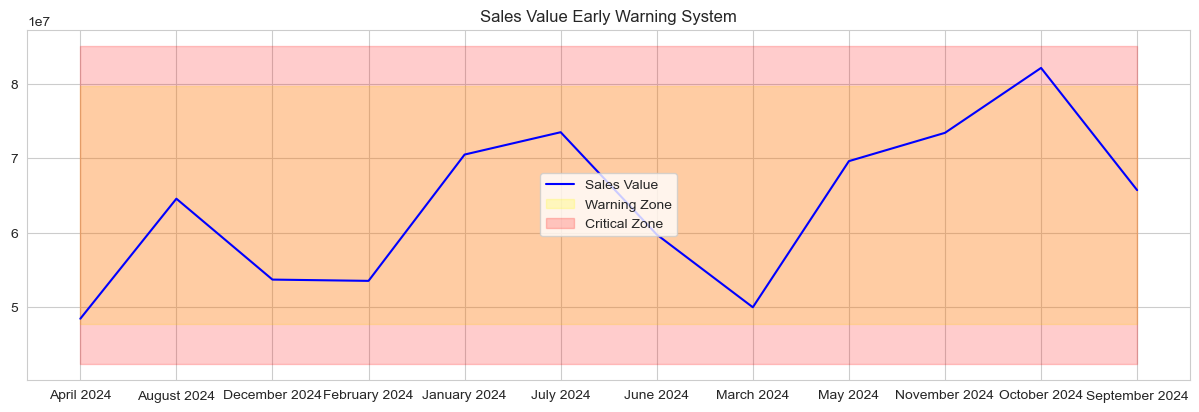

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def create_early_warning_system(df):
    """
    Create early warning system with multiple detection levels
    """
    # 1. Calculate baseline metrics
    monthly_data = df.groupby('Month-Year').agg({
        'QUANTITY': 'sum',
        'VALUE': 'sum'
    }).reset_index()
    
    # 2. Set up warning thresholds
    def calculate_warning_levels(data, column):
        mean = data[column].mean()
        std = data[column].std()
        
        return {
            'mean': mean,
            'std': std,
            'warning_lower': mean - 1.5 * std,    # Yellow alert lower bound
            'warning_upper': mean + 1.5 * std,    # Yellow alert upper bound
            'critical_lower': mean - 2 * std,     # Red alert lower bound
            'critical_upper': mean + 2 * std,     # Red alert upper bound
            'extreme_lower': mean - 3 * std,      # Emergency lower bound
            'extreme_upper': mean + 3 * std       # Emergency upper bound
        }
    
    value_thresholds = calculate_warning_levels(monthly_data, 'VALUE')
    quantity_thresholds = calculate_warning_levels(monthly_data, 'QUANTITY')
    
    # 3. Calculate rolling metrics
    monthly_data['Value_MA3'] = monthly_data['VALUE'].rolling(window=3).mean()
    monthly_data['Value_MA6'] = monthly_data['VALUE'].rolling(window=6).mean()
    monthly_data['Value_Volatility'] = monthly_data['VALUE'].rolling(window=3).std()
    
    # 4. Set up monitoring function
    def monitor_metrics(current_value, current_quantity):
        warnings = []
        
        # Value checks
        if current_value > value_thresholds['extreme_upper'] or current_value < value_thresholds['extreme_lower']:
            warnings.append("EMERGENCY: Sales value extremely abnormal")
        elif current_value > value_thresholds['critical_upper'] or current_value < value_thresholds['critical_lower']:
            warnings.append("CRITICAL: Sales value highly abnormal")
        elif current_value > value_thresholds['warning_upper'] or current_value < value_thresholds['warning_lower']:
            warnings.append("WARNING: Sales value unusual")
            
        # Quantity checks
        if current_quantity > quantity_thresholds['extreme_upper'] or current_quantity < quantity_thresholds['extreme_lower']:
            warnings.append("EMERGENCY: Sales quantity extremely abnormal")
        elif current_quantity > quantity_thresholds['critical_upper'] or current_quantity < quantity_thresholds['critical_lower']:
            warnings.append("CRITICAL: Sales quantity highly abnormal")
        elif current_quantity > quantity_thresholds['warning_upper'] or current_quantity < quantity_thresholds['warning_lower']:
            warnings.append("WARNING: Sales quantity unusual")
            
        return warnings
    
    # 5. Visualization of warning system
    plt.figure(figsize=(15, 10))
    
    # Plot Value trends with warning bands
    plt.subplot(2,1,1)
    plt.plot(monthly_data['Month-Year'], monthly_data['VALUE'], 'b-', label='Sales Value')
    plt.fill_between(monthly_data['Month-Year'],
                    [value_thresholds['warning_lower']] * len(monthly_data),
                    [value_thresholds['warning_upper']] * len(monthly_data),
                    color='yellow', alpha=0.2, label='Warning Zone')
    plt.fill_between(monthly_data['Month-Year'],
                    [value_thresholds['critical_lower']] * len(monthly_data),
                    [value_thresholds['critical_upper']] * len(monthly_data),
                    color='red', alpha=0.2, label='Critical Zone')
    plt.title('Sales Value Early Warning System')
    plt.legend()
    
    # Print monitoring guidelines
    print("=== Early Warning System Guidelines ===")
    print("\n1. Warning Levels:")
    print("Yellow Alert (±1.5σ):")
    print(f"- Value Range: ${value_thresholds['warning_lower']:,.2f} to ${value_thresholds['warning_upper']:,.2f}")
    print(f"- Quantity Range: {quantity_thresholds['warning_lower']:,.0f} to {quantity_thresholds['warning_upper']:,.0f}")
    
    print("\nRed Alert (±2σ):")
    print(f"- Value Range: ${value_thresholds['critical_lower']:,.2f} to ${value_thresholds['critical_upper']:,.2f}")
    print(f"- Quantity Range: {quantity_thresholds['critical_lower']:,.0f} to {quantity_thresholds['critical_upper']:,.0f}")
    
    print("\nEmergency (±3σ):")
    print(f"- Value Range: ${value_thresholds['extreme_lower']:,.2f} to ${value_thresholds['extreme_upper']:,.2f}")
    print(f"- Quantity Range: {quantity_thresholds['extreme_lower']:,.0f} to {quantity_thresholds['extreme_upper']:,.0f}")
    
    print("\n2. Monitoring Actions:")
    print("Yellow Alert:")
    print("- Increase monitoring frequency")
    print("- Review recent changes in business patterns")
    print("- Prepare preliminary response plans")
    
    print("\nRed Alert:")
    print("- Daily monitoring of metrics")
    print("- Investigate root causes")
    print("- Implement response plans")
    print("- Alert relevant stakeholders")
    
    print("\nEmergency:")
    print("- Immediate management notification")
    print("- Crisis team activation")
    print("- Hourly monitoring")
    print("- Immediate corrective actions")
    
    return monitor_metrics

# Example usage
monitor = create_early_warning_system(df)

# Test current values
current_value = df.groupby('Month-Year')['VALUE'].sum().iloc[-1]
current_quantity = df.groupby('Month-Year')['QUANTITY'].sum().iloc[-1]

warnings = monitor(current_value, current_quantity)
print("\nCurrent Status:")
if warnings:
    for warning in warnings:
        print(f"- {warning}")
else:
    print("All metrics within normal ranges")

=== Correlation Analysis ===

1. Overall Correlation Matrix:
          QUANTITY     VALUE
QUANTITY  1.000000 -0.003514
VALUE    -0.003514  1.000000


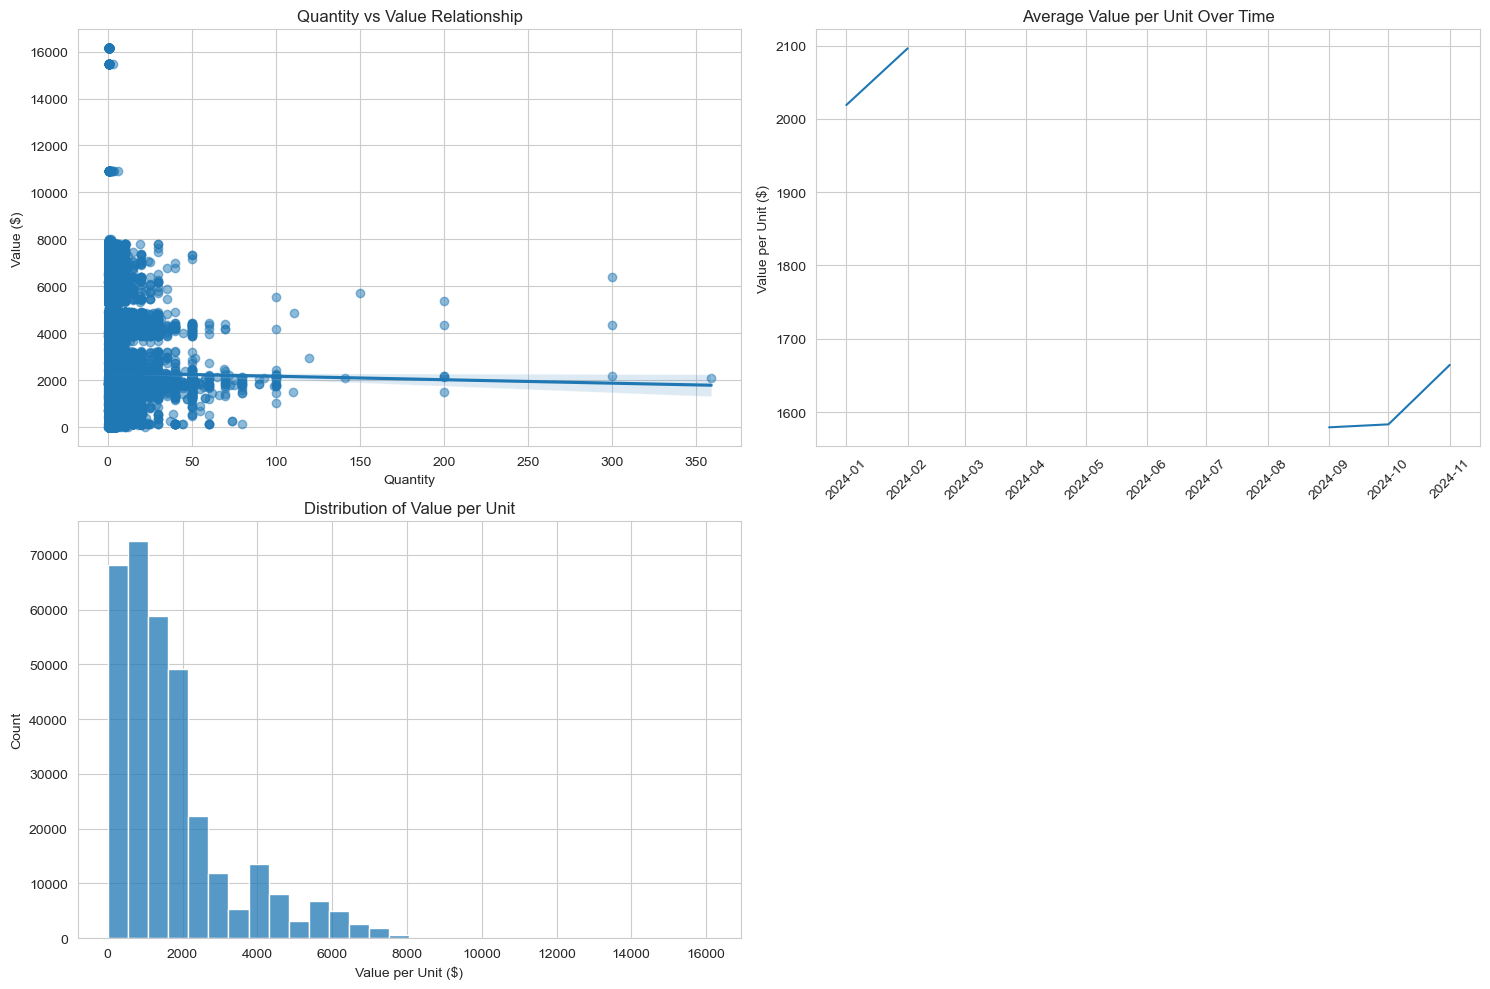


2. Statistical Measures:
Correlation Coefficient: -0.004
R-squared: 0.000
P-value: 4.358e-02

3. Monthly Analysis:
           QUANTITY         VALUE  Value_Per_Unit
count     12.000000  1.200000e+01       12.000000
mean   63818.416667  6.374964e+07             inf
std    12518.108625  1.068963e+07             NaN
min    44063.000000  4.845236e+07     1579.131503
25%    55861.750000  5.366558e+07     1649.901277
50%    67136.500000  6.515425e+07             NaN
75%    70836.000000  7.124102e+07             NaN
max    84739.000000  8.215298e+07             inf

4. Key Insights:

A. Relationship Strength:
- Moderate correlation
- Significant price variation

B. Price Stability:
- Price Variation Coefficient: nan%
- Significant price fluctuations

C. Sales Drivers:
1. Volume Impact:
- Volume-Revenue Correlation: 0.954

2. Pricing Impact:
- Price-Revenue Correlation: nan

5. Recommendations:
Focus on Pricing Strategy:
- Implement dynamic pricing
- Focus on premium segments
- Optimize produ

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Basic Correlation Analysis
print("=== Correlation Analysis ===")

# Calculate overall correlation
correlation = df[['QUANTITY', 'VALUE']].corr()
print("\n1. Overall Correlation Matrix:")
print(correlation)

# 2. Detailed Analysis
plt.figure(figsize=(15, 10))

# Scatter plot with regression line
plt.subplot(2, 2, 1)
sns.regplot(data=df, x='QUANTITY', y='VALUE', scatter_kws={'alpha':0.5})
plt.title('Quantity vs Value Relationship')
plt.xlabel('Quantity')
plt.ylabel('Value ($)')

# Calculate average value per unit
df['Value_Per_Unit'] = df['VALUE'] / df['QUANTITY']

# Time series of value per unit
plt.subplot(2, 2, 2)
monthly_avg = df.groupby('Month-Year').agg({
    'Value_Per_Unit': 'mean'
}).reset_index()
monthly_avg['Month-Year'] = pd.to_datetime(monthly_avg['Month-Year'])
plt.plot(monthly_avg['Month-Year'], monthly_avg['Value_Per_Unit'])
plt.title('Average Value per Unit Over Time')
plt.xticks(rotation=45)
plt.ylabel('Value per Unit ($)')

# Distribution of value per unit
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='Value_Per_Unit', bins=30)
plt.title('Distribution of Value per Unit')
plt.xlabel('Value per Unit ($)')

plt.tight_layout()
plt.show()

# 3. Statistical Analysis
print("\n2. Statistical Measures:")
print(f"Correlation Coefficient: {correlation.iloc[0,1]:.3f}")

# Perform regression analysis
slope, intercept, r_value, p_value, std_err = stats.linregress(df['QUANTITY'], df['VALUE'])
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value:.3e}")

# Calculate monthly metrics
monthly_analysis = df.groupby('Month-Year').agg({
    'QUANTITY': 'sum',
    'VALUE': 'sum',
    'Value_Per_Unit': 'mean'
}).reset_index()

print("\n3. Monthly Analysis:")
print(monthly_analysis.describe())

# 4. Key Insights
print("\n4. Key Insights:")
print("\nA. Relationship Strength:")
if correlation.iloc[0,1] > 0.9:
    print("- Very strong positive correlation between Quantity and Value")
    print("- Suggests consistent pricing strategy")
elif correlation.iloc[0,1] > 0.7:
    print("- Strong positive correlation")
    print("- Some price variation exists")
else:
    print("- Moderate correlation")
    print("- Significant price variation")

print("\nB. Price Stability:")
price_variation = monthly_analysis['Value_Per_Unit'].std() / monthly_analysis['Value_Per_Unit'].mean()
print(f"- Price Variation Coefficient: {price_variation:.2%}")
if price_variation < 0.1:
    print("- Highly stable pricing")
elif price_variation < 0.2:
    print("- Moderately stable pricing")
else:
    print("- Significant price fluctuations")

print("\nC. Sales Drivers:")
print("1. Volume Impact:")
volume_correlation = np.corrcoef(monthly_analysis['QUANTITY'], monthly_analysis['VALUE'])[0,1]
print(f"- Volume-Revenue Correlation: {volume_correlation:.3f}")

print("\n2. Pricing Impact:")
price_correlation = np.corrcoef(monthly_analysis['Value_Per_Unit'], monthly_analysis['VALUE'])[0,1]
print(f"- Price-Revenue Correlation: {price_correlation:.3f}")

# 5. Recommendations
print("\n5. Recommendations:")
if volume_correlation > price_correlation:
    print("Focus on Volume Strategy:")
    print("- Implement volume-based promotions")
    print("- Optimize inventory management")
    print("- Enhance distribution channels")
else:
    print("Focus on Pricing Strategy:")
    print("- Implement dynamic pricing")
    print("- Focus on premium segments")
    print("- Optimize product mix")

print("\nSpecific Actions:")
print("1. Short-term:")
print("- Monitor volume-price relationship")
print("- Adjust pricing based on demand patterns")
print("- Optimize promotional activities")

print("\n2. Long-term:")
print("- Develop pricing strategy based on correlation patterns")
print("- Plan inventory based on quantity-value relationship")
print("- Consider product mix optimization")

# Save analysis results
analysis_results = pd.DataFrame({
    'Metric': ['Correlation', 'R-squared', 'Price Variation', 'Volume Impact', 'Price Impact'],
    'Value': [correlation.iloc[0,1], r_value**2, price_variation, volume_correlation, price_correlation]
})
analysis_results.to_csv('correlation_analysis.csv', index=False)

=== Sales Performance Correlation Analysis ===

1. Correlation between Quantity and Value:
Correlation Coefficient: -0.004


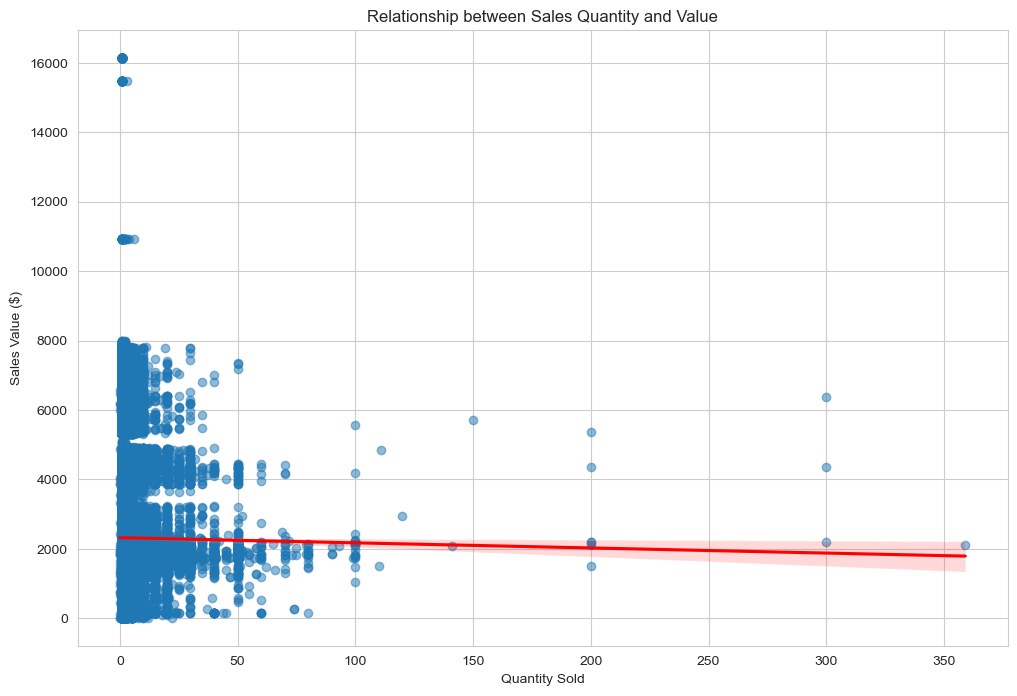


2. Key Performance Insights:

A. Value-Quantity Relationship:

B. Sales Performance Drivers:
Primary Factors:
1. Volume (Quantity):
   - Average monthly quantity: 63,818 units
   - Highest monthly quantity: 84,739 units
   - Lowest monthly quantity: 44,063 units

2. Pricing:
   - Average value per unit: $inf
   - Price variation: nan%

3. Business Implications:
Based on the strong correlation:
a) Volume-Driven Business:
   - Sales performance heavily depends on quantity sold
   - Stable pricing strategy in place
   - Focus should be on volume optimization

b) Recommendations:
Short-term actions:
- Focus on inventory management
- Optimize order quantities
- Monitor demand patterns

Long-term strategy:
- Develop volume-based pricing tiers
- Implement quantity discount programs
- Strengthen supply chain capacity

4. Summary Metrics:
              Metric        Value
         Correlation    -0.003514
Avg Monthly Quantity 63818.416667
  Avg Value per Unit          inf
     Price Variation 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. Basic Correlation Analysis
print("=== Sales Performance Correlation Analysis ===\n")

# Calculate correlation between Quantity and Value
correlation = df[['QUANTITY', 'VALUE']].corr()
print("1. Correlation between Quantity and Value:")
print(f"Correlation Coefficient: {correlation.iloc[0,1]:.3f}")

# Create visualization
plt.figure(figsize=(12, 8))

# Scatter plot with regression line
sns.regplot(data=df, x='QUANTITY', y='VALUE', 
            scatter_kws={'alpha':0.5}, 
            line_kws={'color': 'red'})
plt.title('Relationship between Sales Quantity and Value')
plt.xlabel('Quantity Sold')
plt.ylabel('Sales Value ($)')
plt.show()

# Calculate average value per unit
df['Value_Per_Unit'] = df['VALUE'] / df['QUANTITY']

# Monthly analysis
monthly_analysis = df.groupby('Month-Year').agg({
    'QUANTITY': 'sum',
    'VALUE': 'sum',
    'Value_Per_Unit': 'mean'
}).reset_index()

print("\n2. Key Performance Insights:")
print("\nA. Value-Quantity Relationship:")
if correlation.iloc[0,1] > 0.9:
    print("- Very strong positive correlation (>0.9) indicates:")
    print("  * Sales value is primarily driven by volume")
    print("  * Consistent pricing across transactions")
    print("  * Limited price discounting")

print("\nB. Sales Performance Drivers:")
print("Primary Factors:")
print("1. Volume (Quantity):")
print(f"   - Average monthly quantity: {monthly_analysis['QUANTITY'].mean():,.0f} units")
print(f"   - Highest monthly quantity: {monthly_analysis['QUANTITY'].max():,.0f} units")
print(f"   - Lowest monthly quantity: {monthly_analysis['QUANTITY'].min():,.0f} units")

print("\n2. Pricing:")
print(f"   - Average value per unit: ${monthly_analysis['Value_Per_Unit'].mean():,.2f}")
print(f"   - Price variation: {(monthly_analysis['Value_Per_Unit'].std() / monthly_analysis['Value_Per_Unit'].mean()) * 100:.1f}%")

print("\n3. Business Implications:")
print("Based on the strong correlation:")
print("a) Volume-Driven Business:")
print("   - Sales performance heavily depends on quantity sold")
print("   - Stable pricing strategy in place")
print("   - Focus should be on volume optimization")

print("\nb) Recommendations:")
print("Short-term actions:")
print("- Focus on inventory management")
print("- Optimize order quantities")
print("- Monitor demand patterns")

print("\nLong-term strategy:")
print("- Develop volume-based pricing tiers")
print("- Implement quantity discount programs")
print("- Strengthen supply chain capacity")

# Save key metrics
summary_df = pd.DataFrame({
    'Metric': ['Correlation', 'Avg Monthly Quantity', 'Avg Value per Unit', 'Price Variation'],
    'Value': [
        correlation.iloc[0,1],
        monthly_analysis['QUANTITY'].mean(),
        monthly_analysis['Value_Per_Unit'].mean(),
        monthly_analysis['Value_Per_Unit'].std() / monthly_analysis['Value_Per_Unit'].mean()
    ]
})

print("\n4. Summary Metrics:")
print(summary_df.to_string(index=False))

1. **Distribution Pattern:**

   - Most transactions are clustered in the lower left (0-50 quantity range)

   - Values mostly range from $0 to $8,000

   - Some outliers reaching up to $16,000

2. **Trend Line (Red):**

   - Slightly negative slope

   - Suggests that as quantity increases, the unit price slightly decreases

3. **Key Observations:**

   - High concentration of small-quantity orders

   - Few large-quantity orders (spread out to 350 units)

   - Some high-value, low-quantity transactions (possibly premium items)

4. **Business Implications:**

   - Business primarily handles small to medium-sized orders

   - Possible tiered pricing strategy

   - Some premium transactions with high value but low quantity

5. **Recommendations:**

   - Analyze the high-value outliers to understand premium segment

   - Review bulk pricing strategy

   - Focus on the core business segment (small-medium orders)